In [6]:
import numpy as np
import pandas as pd
import pickle
import os
from lib.read.read_data import dataset,Datasets,readDataWithRawScore
from math import copysign

from sklearn.pipeline import Pipeline

# feature extractors
from sklearn.decomposition import PCA
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
# finetuning
from sklearn.model_selection import GridSearchCV
# validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# plot
import matplotlib.pyplot as plt
% matplotlib inline

In [19]:
def draw_roc_curve(fpr,tpr,score):
    '''
    draw roc curve
    '''
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
def run_display_output(classifier,test,DRAW=False):
    '''
    get confusion matrix and auc score for test dataset
    (optional) draw roc curve
    '''
    pred = classifier.predict(test[0])
    tn, fp, fn, tp = confusion_matrix(test[1],pred).ravel()#confusion matrix
    print(tn,fp,fn,tp)
    sensitivity = tp/(fn+tp)
    specificity = tn/(fp+tn)
    prods = classifier.predict_proba(test[0])[:,1]
    fpr, tpr, _ = metrics.roc_curve(test[1], prods)
    score = metrics.auc(fpr,tpr) #auc score
    if DRAW:
        draw_roc_curve(fpr,tpr,score)

    return sensitivity, specificity, score

def display_res_gavin_and_best_model(param_grid,pipeline,mvid,filename=None,DRAW=False):
    '''
    use model defined by pipeline to fit mvid Dataset
    gridsearchCV determine the parameters given in param_grid
    (optional) save the model in path given in filename
    '''
    classifier = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid)

    print('Start training...')
    classifier.fit(mvid[0],mvid[1])
    print('Model Description:\n',classifier.best_estimator_)
    if filename:
        pickle.dump(classifier,open(os.path.join('/home/shuang/projects/eqtm/model',filename),'wb'))
        print('Saved model to path:',filename)
    sensitivity,specificity,score = run_display_output(classifier,[mvid[2],mvid[3]],DRAW=DRAW)
    print('>>> best model results: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
    format(sensitivity,specificity,score,prec=3))
    return classifier

def tryTwoQuickModels(eqtm_data,filename=None,DRAW=False):
    # get the error cases and the correct cases
    feature_list = [col for col in eqtm_data.train.values.columns
                    if col not in ['zscore','cpgName','']]
    train_data = eqtm_data.train.values[feature_list]
    test_data = eqtm_data.test.values[feature_list]
    
    # ============random forest================
    pipeline_ranfor = Pipeline(steps=[('ranfor',
                                       RandomForestClassifier())])
    n_estimators = [10,50,100]
    class_weight = ['balanced',{1:4,0:1},{1:2,0:1}]
    param_grid_ranfor = [{'ranfor__n_estimators':n_estimators,
                        'ranfor__class_weight':class_weight}]
    classifier_ranfor = display_res_gavin_and_best_model(
                        param_grid_ranfor,
                        pipeline_ranfor,
                        [train_data,
                         eqtm_data.train.labels,
                         test_data,
                         eqtm_data.test.labels],
                        DRAW=DRAW,
                        filename=filename)
    # ==========================================
    
    # ===========knn============================
    pipeline_kneighbor = Pipeline(steps=[('kneighbor',
                                          KNeighborsClassifier())])
    # print(pipeline_kneighbor.get_params().keys())
    n_neighbors = range(2,10)
    weights = ['uniform','distance']
    # algorithms = ['auto']
    # leaf_size = [20,30,40,50]
    # p = [1,2,3]
    param_grid_kneighbor = [{'kneighbor__n_neighbors':n_neighbors,
                            'kneighbor__weights':weights}]#,
                            # 'kneighbor__algorithms':algorithms}]#,
                            # 'kneighbor__leaf_size':leaf_size,
                            # 'kneighbor__p':p}]
    classifier_kneighbor = display_res_gavin_and_best_model(
                            param_grid_kneighbor,
                            pipeline_kneighbor,
                            [train_data,
                         eqtm_data.train.labels,
                         test_data,
                         eqtm_data.test.labels],
                         DRAW=DRAW)
    # ==========================================
    
    
#     model = LogisticRegression()
#     model.fit(train_data,eqtm_data.train.labels)
    pred = classifier_kneighbor.predict(test_data)
    return pred,classifier_ranfor,classifier_kneighbor

# add TSS, Mean, Var

Processing dataset: bonder_withzscore_withMeanVar.csv
Not using features: ['cpgName_split', 'TSS_Distance', 'methyMean', 'methyVar']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
303 61 88 259


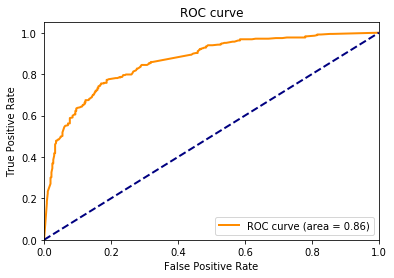

>>> best model results: sensitivity: 0.746	specificity: 0.832	auc:0.8627719542705133
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance'))])
303 61 93 254


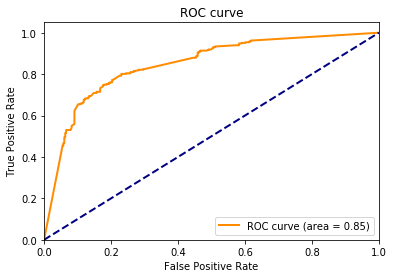

>>> best model results: sensitivity: 0.732	specificity: 0.832	auc:0.8469613959527504
Not using features: ['cpgName_split', 'methyMean', 'methyVar']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
168 179 61 303


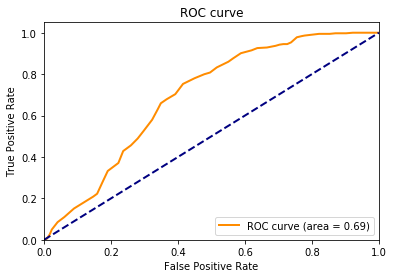

>>> best model results: sensitivity: 0.832	specificity: 0.484	auc:0.6925808341514393
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
230 117 75 289


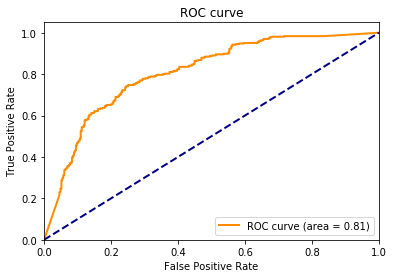

>>> best model results: sensitivity: 0.794	specificity: 0.663	auc:0.8069560122874244
Not using features: ['cpgName_split', 'TSS_Distance', 'methyVar']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 4, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
308 56 119 228


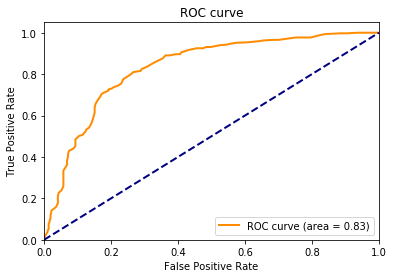

>>> best model results: sensitivity: 0.657	specificity: 0.846	auc:0.8316971213224816
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'))])
243 121 89 258


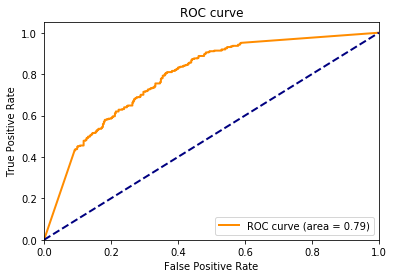

>>> best model results: sensitivity: 0.744	specificity: 0.668	auc:0.7879587991259462
Not using features: ['cpgName_split', 'TSS_Distance', 'methyMean']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
273 67 81 290


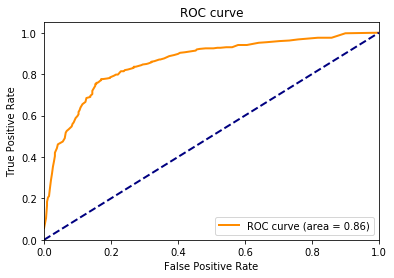

>>> best model results: sensitivity: 0.782	specificity: 0.803	auc:0.8578801331853496
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance'))])
270 70 85 286


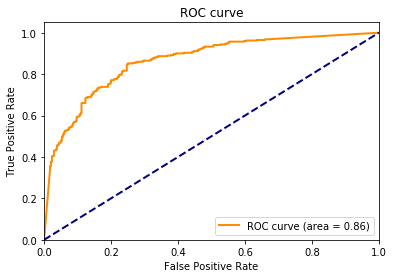

>>> best model results: sensitivity: 0.771	specificity: 0.794	auc:0.8632471856667194
Not using features: ['cpgName_split', 'methyMean']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 4, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
218 138 67 288


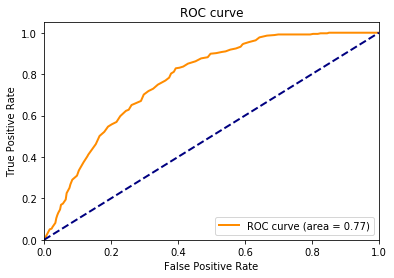

>>> best model results: sensitivity: 0.811	specificity: 0.612	auc:0.773876404494382
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
247 109 52 303


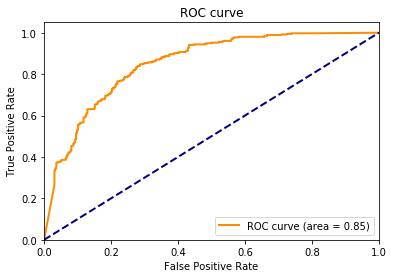

>>> best model results: sensitivity: 0.854	specificity: 0.694	auc:0.8507635701851558
Not using features: ['cpgName_split', 'methyVar']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
192 166 81 272


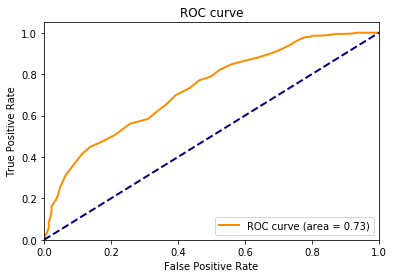

>>> best model results: sensitivity: 0.771	specificity: 0.536	auc:0.7286506718154051
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
267 91 80 273


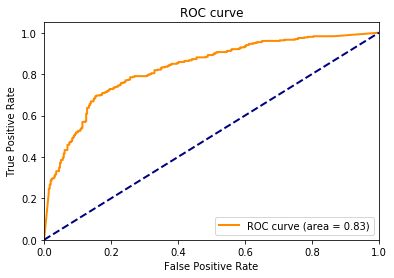

>>> best model results: sensitivity: 0.773	specificity: 0.746	auc:0.8288413755994113
Not using features: ['cpgName_split', 'TSS_Distance']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
318 42 140 211


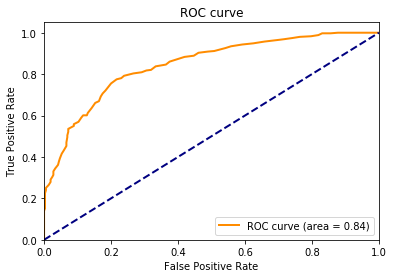

>>> best model results: sensitivity: 0.601	specificity: 0.883	auc:0.8443771763216207
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
290 70 102 249


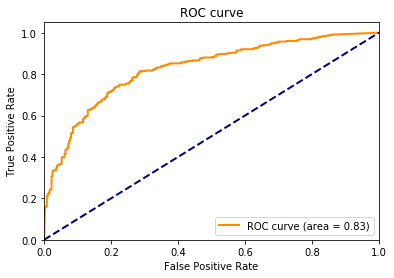

>>> best model results: sensitivity: 0.709	specificity: 0.806	auc:0.826297879075657
Not using features: ['cpgName_split']
Raw data loaded.
Data Normalized.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
319 36 171 185


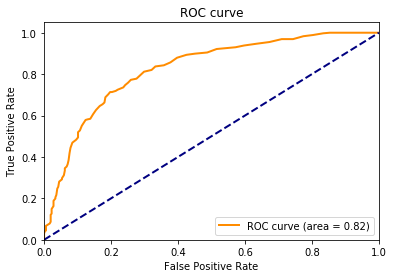

>>> best model results: sensitivity: 0.52	specificity: 0.899	auc:0.823975312549454
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
284 71 102 254


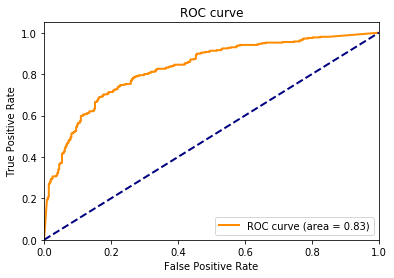

>>> best model results: sensitivity: 0.713	specificity: 0.800	auc:0.8286200348156354


In [20]:
def load_data(path,exclude):
        data = pd.read_csv(path,sep=',',index_col=0)
        def binarize(row):
            if row > 0:
                return 1
            else:
                return 0
        data['direction'] = data['zscore'].apply(binarize)
        print('Raw data loaded.')
        features = [feat for feat in data.columns if feat not in exclude]
        dataset = readDataWithRawScore(data[features],'direction')
        return dataset

def analyse(filepath):
    exclude1 = ['cpgName_split','TSS_Distance','methyMean','methyVar']
    exclude2 = ['cpgName_split','methyMean','methyVar']
    exclude3 = ['cpgName_split','TSS_Distance','methyVar']
    exclude4 = ['cpgName_split','TSS_Distance','methyMean']
    exclude5 = ['cpgName_split','methyMean']
    exclude6 = ['cpgName_split','methyVar']
    exclude7 = ['cpgName_split','TSS_Distance']
    exclude8 = ['cpgName_split']
    for exclude in [exclude1,exclude2,exclude3,exclude4,exclude5,exclude6,exclude7,exclude8]:
        print('Not using features:',exclude)
        dataset = load_data(filepath,exclude=exclude)
        pred,ranfor,kneighbor = tryTwoQuickModels(eqtm_data=dataset,DRAW=True)
        
    

data_folder = '/home/shuang/projects/eqtm/data/dataReadyForModeling/overlapRatioTssMeanVar'
#filenames = ['etCpG_withZscoreTss_withMeanVar.csv',
#            'gtCpG_withZscoreTss_withMeanVar.csv']#,
            #'bonder_withzscore_withMeanVar.csv',
            #'westra_all_with_zscore_withMeanVar.csv',
            #'westra_bonderfeat_with_zscore_withMeanVar.csv']

et_filepath = os.path.join(data_folder,'etCpG_withZscoreTss_withMeanVar.csv')
gt_filepath = os.path.join(data_folder,'gtCpG_withZscoreTss_withMeanVar.csv')

# tried with gt/et files without TSS distance but the files are now moved to somewhere I couldn't find so cannot reproduce the results below...

In [8]:
if __name__=='__main__':
    
    def load_bonderWestraData(path):
        data = pd.read_csv(path,sep=',',index_col=0)
        def binarize(row):
            if row > 0:
                return 1
            else:
                return 0
        data['direction'] = data['zscore'].apply(binarize)
        print('Raw data loaded.')
        dataset = readDataWithRawScore(data,'direction')
        return dataset
    
    etCpG_path = 'data/etCpG_withzscore.csv'
    gtCpG_path = 'data/gtCpG_withzscore.csv'
    
    bonder_path = 'data/Newbonder_withzscore.csv'
    westra_allFeat_path = 'data/Newwestra_all_with_zscore.csv'
    westra_bonderFeat_path = 'data/Newwestra_bonderfeat_with_zscore.csv'

    etCpG = load_bonderWestraData(etCpG_path)
    gtCpG = load_bonderWestraData(gtCpG_path)
    
    bonder = load_bonderWestraData(bonder_path)
    westra_allFeat = load_bonderWestraData(westra_allFeat_path)
    westra_bonderFeat = load_bonderWestraData(westra_bonderFeat_path)

    print('etCpG dataset loaded.',etCpG.train.values.shape)
    print('gtCpG dataset loaded.',gtCpG.train.values.shape)
    print('bonder dataset loaded.',bonder.train.values.shape)
    print('westra with all features dataset loaded.',westra_allFeat.train.values.shape)
    print('westra with bonder features dataset loaded.',westra_bonderFeat.train.values.shape)

FileNotFoundError: File b'data/etCpG_withzscore.csv' does not exist

In [5]:
TSS_et_path = os.path.join('data','TSS_distances_et0.csv')
TSS_gt_path = os.path.join('data','TSS_distances_gt0.csv')
colnames = ['cpgName','TSSdistances']
tss_et = pd.read_csv(TSS_et_path,sep=',').rename(index=str,columns={'Unnamed: 0':'cpgName','0':'TSSdistances'})
tss_gt = pd.read_csv(TSS_gt_path,sep=',').rename(index=str,columns={'Unnamed: 0':'cpgName','0':'TSSdistances'})

tss_et_dic = tss_et.set_index(['cpgName']).to_dict()
def addTSSdistances(row):
    try:
        return tss_et_dic[row]
    except:
        return None
etCpG_path = 'data/etCpG_withzscore.csv'
datatable = pd.read_csv(etCpG_path,sep=',')
# datatable['cpgName']
datatable['TSSdistances'] = datatable['cpgName'].apply(addTSSdistances)
datatble.TSSdistances.head()

FileNotFoundError: File b'data/etCpG_withzscore.csv' does not exist

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
3560 929 1222 1403


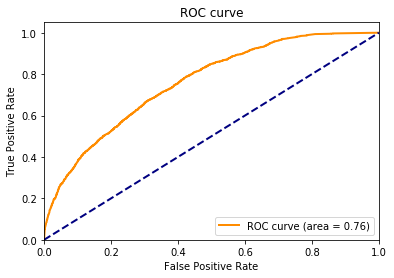

>>> best model results: sensitivity: 0.534	specificity: 0.793	auc:0.759345150579724
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
3511 978 1201 1424


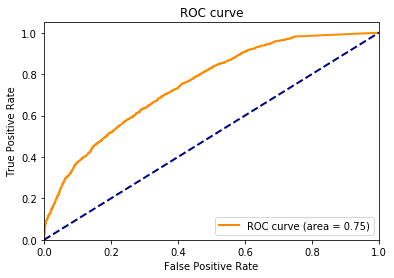

>>> best model results: sensitivity: 0.542	specificity: 0.782	auc:0.7501106408257221


In [7]:
# insignificant cpg sites
pred2,ranfor2,kneighbor2 = tryTwoQuickModels(eqtm_data=gtCpG,DRAW=True)

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
1373 86 153 263


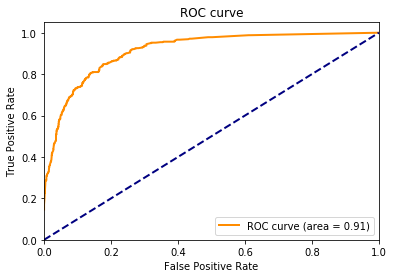

>>> best model results: sensitivity: 0.632	specificity: 0.941	auc:0.9138660238835872
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance'))])
1358 101 144 272


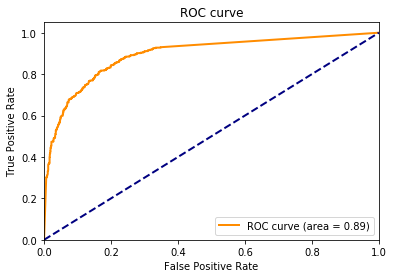

>>> best model results: sensitivity: 0.654	specificity: 0.931	auc:0.8938336980017928


In [8]:
# significant cpg sites
pred1,ranfor1,kneighbor1 = tryTwoQuickModels(etCpG,DRAW=True)

In [16]:
ranfor1.best_estimator_.steps[0][1].feature_importances_

array([0.03087894, 0.05595533, 0.03024038, 0.03191969, 0.02900305,
       0.04257939, 0.03317347, 0.02728278, 0.02139927, 0.03505902,
       0.02908328, 0.03242025, 0.02308338, 0.02633461, 0.03521247,
       0.03392156, 0.02042051, 0.0263823 , 0.03859149, 0.02939774,
       0.03246673, 0.02961903, 0.03319985, 0.02569909, 0.02769037,
       0.04431786, 0.01420674, 0.02385449, 0.03973757, 0.03122075,
       0.02277296, 0.04287566])

In [17]:
ranfor2.best_estimator_.steps[0][1].feature_importances_

array([0.03724524, 0.03633823, 0.03288275, 0.03648667, 0.02586149,
       0.0364783 , 0.03210832, 0.03274731, 0.02785152, 0.03428686,
       0.03071978, 0.02960729, 0.02582398, 0.02671152, 0.03297843,
       0.03191408, 0.0250767 , 0.02641252, 0.0377409 , 0.02732548,
       0.02816647, 0.02917344, 0.03324759, 0.03029437, 0.03288892,
       0.0383036 , 0.01393237, 0.02626479, 0.03570979, 0.03392212,
       0.02937012, 0.04212905])

In [36]:
etCpG_allFeat = etCpG.train.values.columns[1:-1]
etCpG_allFeat_sorted = etCpG_allFeat[np.argsort(ranfor1.best_estimator_.steps[0][1].feature_importances_)]
print(etCpG_allFeat_sorted)

Index(['H3K9me1_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K23ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H4K91ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2AK9ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K14ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2AK5ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2BK120ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2BK15ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4me2_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2BK12ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K36me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K9ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K79me2_Imput

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
276 71 124 240


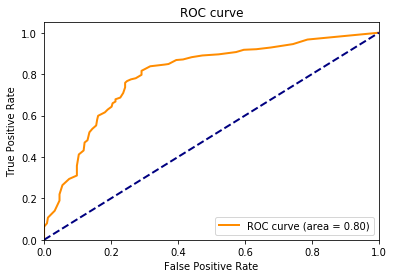

>>> best model results: sensitivity: 0.659	specificity: 0.795	auc:0.7967310067454161
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
265 82 89 275


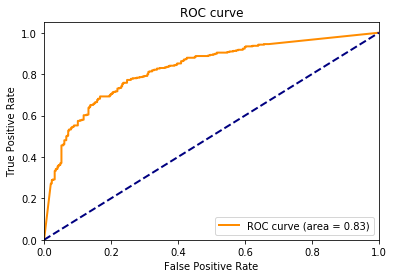

>>> best model results: sensitivity: 0.755	specificity: 0.764	auc:0.82632533172879


In [22]:
# bonder
pred_bonder,ranfor_bonder,kneighbor_bonder = tryTwoQuickModels(bonder,DRAW=True)

In [23]:
ranfor_bonder.best_estimator_.steps[0][1].feature_importances_

array([0.19865094, 0.03801289, 0.14826535, 0.07681438, 0.09376676,
       0.11634271, 0.32814697])

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
412 39 116 315


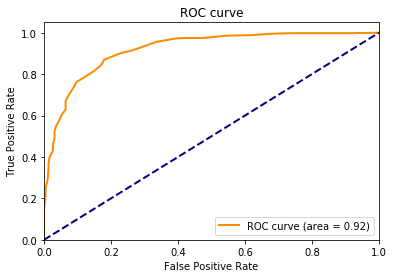

>>> best model results: sensitivity: 0.731	specificity: 0.914	auc:0.9194494317860283
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])
381 70 93 338


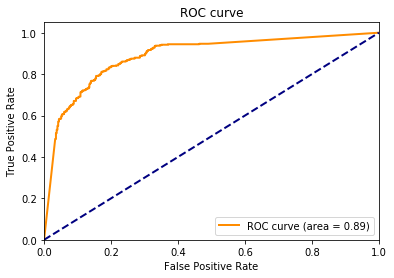

>>> best model results: sensitivity: 0.784	specificity: 0.845	auc:0.8873758237687839


array([0.02551524, 0.08010618, 0.03308709, 0.03332518, 0.02907633,
       0.03051709, 0.02579064, 0.02714579, 0.021494  , 0.02352622,
       0.02170594, 0.02367124, 0.02472536, 0.03274481, 0.03866861,
       0.02580709, 0.02190719, 0.01766956, 0.02900774, 0.02115682,
       0.03365727, 0.03123768, 0.0271065 , 0.02795075, 0.02987204,
       0.03759298, 0.0089958 , 0.02070783, 0.03102278, 0.02375033,
       0.02659227, 0.03584878, 0.07901689])

In [25]:
# westra_allfeat
pred_westra_all,ranfor_westra_all,kneighbor_westra_all = tryTwoQuickModels(westra_allFeat,DRAW=True)
westra_allFeat_importances = ranfor_westra_all.best_estimator_.steps[0][1].feature_importances_

In [32]:
westra_allFeat_importances = ranfor_westra_all.best_estimator_.steps[0][1].feature_importances_
westra_allFeat_importances[np.argsort(westra_allFeat_importances)]

array([0.0089958 , 0.01766956, 0.02070783, 0.02115682, 0.021494  ,
       0.02170594, 0.02190719, 0.02352622, 0.02367124, 0.02375033,
       0.02472536, 0.02551524, 0.02579064, 0.02580709, 0.02659227,
       0.0271065 , 0.02714579, 0.02795075, 0.02900774, 0.02907633,
       0.02987204, 0.03051709, 0.03102278, 0.03123768, 0.03274481,
       0.03308709, 0.03332518, 0.03365727, 0.03584878, 0.03759298,
       0.03866861, 0.07901689, 0.08010618])

In [35]:
westra_allFeat_training = westra_allFeat.train.values.columns[1:-1]
westra_allFeat_training_sorted = westra_allFeat_training[np.argsort(westra_allFeat_importances)]
print(westra_allFeat_training_sorted)

Index(['H3K9me1_ImputedGapped_all_celltypes_westra_final_unique_',
       'H2BK15ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K14ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K79me2_ImputedGapped_all_celltypes_westra_final_unique_',
       'H4K91ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K9ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K23ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'DNase_ImputedGapped_all_celltypes_westra_final_unique_',
       'H4K8ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H2BK20ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K4ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K9me3_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K27ac_ImputedGapped_all_celltypes_westra_final_unique_',
       'H3K79me1_ImputedGapped_all_celltypes_westra_final_unique_',
       'H2AK9ac_ImputedGapped_all_celltypes_westra_final_unique

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
280 155 61 386


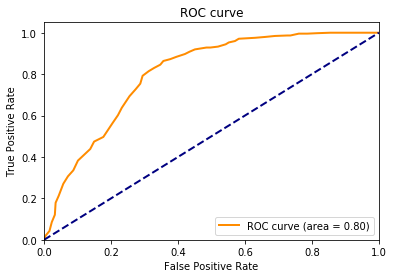

>>> best model results: sensitivity: 0.864	specificity: 0.644	auc:0.8028311347681863
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance'))])
312 123 68 379


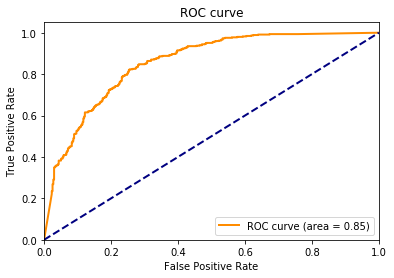

>>> best model results: sensitivity: 0.848	specificity: 0.717	auc:0.8541412738820747


array([0.17070013, 0.0450142 , 0.16086676, 0.08048443, 0.10747821,
       0.12100807, 0.31444821])

In [26]:
# westra_allfeat
pred_westra_bonderFeat,ranfor_westra_bonderFeat,kneighbor_westra_bonderFeat = tryTwoQuickModels(westra_bonderFeat,DRAW=True)
ranfor_westra_bonderFeat.best_estimator_.steps[0][1].feature_importances_